In [1]:
import zstandard
import os
import json
import sys
from datetime import datetime
import logging.handlers


log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())


def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
	chunk = reader.read(chunk_size)
	bytes_read += chunk_size
	if previous_chunk is not None:
		chunk = previous_chunk + chunk
	try:
		return chunk.decode()
	except UnicodeDecodeError:
		if bytes_read > max_window_size:
			raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
		log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
		return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)


def read_lines_zst(file_name):
	with open(file_name, 'rb') as file_handle:
		buffer = ''
		reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
		while True:
			chunk = read_and_decode(reader, 2**27, (2**29) * 2)

			if not chunk:
				break
			lines = (buffer + chunk).split("\n")

			for line in lines[:-1]:
				yield line, file_handle.tell()

			buffer = lines[-1]

		reader.close()

In [2]:
file_path = "data/mbti_comments.zst"
file_size = os.stat(file_path).st_size
file_lines = 0
file_bytes_processed = 0
created = None
field = "subreddit"
value = "mbti"
bad_lines = 0
objs = []
# try:
for line, file_bytes_processed in read_lines_zst(file_path):
    try:
        obj = json.loads(line)
        objs.append(obj)
        created = datetime.fromtimestamp(int(obj['created_utc']))
        temp = obj[field] == value
    except (KeyError, json.JSONDecodeError) as err:
        bad_lines += 1
    file_lines += 1
    if file_lines % 100000 == 0:
        log.info(f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {file_bytes_processed:,}:{(file_bytes_processed / file_size) * 100:.0f}%")

# except Exception as err:
# 	log.info(err)

log.info(f"Complete : {file_lines:,} : {bad_lines:,}")

2016-02-14 15:04:54 : 100,000 : 0 : 27,656,825:9%
2017-01-23 07:48:49 : 200,000 : 0 : 51,250,325:16%
2017-09-05 22:59:29 : 300,000 : 0 : 51,250,325:16%
2018-04-21 10:07:58 : 400,000 : 0 : 67,110,400:21%
2018-10-29 08:38:47 : 500,000 : 0 : 80,217,900:25%
2019-03-28 18:09:00 : 600,000 : 0 : 80,217,900:25%
2019-08-15 03:56:07 : 700,000 : 0 : 92,538,950:29%
2019-11-25 05:23:08 : 800,000 : 0 : 104,073,550:32%
2020-03-05 14:46:06 : 900,000 : 0 : 115,214,925:36%
2020-05-28 08:41:00 : 1,000,000 : 0 : 126,225,225:39%
2020-08-10 00:10:55 : 1,100,000 : 0 : 147,066,150:46%
2020-10-27 03:18:25 : 1,200,000 : 0 : 157,290,000:49%
2021-01-04 02:34:59 : 1,300,000 : 0 : 167,120,625:52%
2021-03-12 14:33:33 : 1,400,000 : 0 : 177,082,325:55%
2021-05-17 17:52:33 : 1,500,000 : 0 : 186,650,800:58%
2021-07-11 10:02:37 : 1,600,000 : 0 : 195,826,050:61%
2021-08-24 19:10:14 : 1,700,000 : 0 : 205,132,375:64%
2021-10-10 23:58:03 : 1,800,000 : 0 : 214,700,850:67%
2021-11-17 11:16:31 : 1,900,000 : 0 : 224,138,250:70%


In [3]:
import pandas as pd
df = pd.DataFrame(objs)

In [4]:
df.keys()

Index(['retrieved_on', 'downs', 'author_flair_css_class', 'distinguished',
       'author_flair_text', 'name', 'edited', 'created_utc', 'id', 'subreddit',
       'author', 'subreddit_id', 'archived', 'body', 'parent_id',
       'score_hidden', 'link_id', 'ups', 'controversiality', 'gilded', 'score',
       'removal_reason', 'likes', 'banned_by', 'user_reports', 'saved',
       'report_reasons', 'approved_by', 'replies', 'num_reports', 'created',
       'mod_reports', 'body_html', 'stickied', 'author_cakeday', 'can_gild',
       'approved_at_utc', 'can_mod_post', 'collapsed', 'collapsed_reason',
       'banned_at_utc', 'is_submitter', 'permalink', 'subreddit_type',
       'mod_note', 'mod_reason_by', 'mod_reason_title', 'no_follow',
       'send_replies', 'author_flair_template_id',
       'author_flair_background_color', 'author_flair_richtext',
       'author_flair_text_color', 'author_flair_type', 'rte_mode',
       'author_created_utc', 'author_fullname', 'subreddit_name_prefixed',


- "author_flair_text"
- "id"
- "title": titolo del post
- "selftext": testo del post
- "is_self": indicates whether the post is a text post (i.e. not linking outside) or not — I used this to filter out any image or url posts.
- 

In [5]:
cols = [df['author_flair_css_class'], df['author_flair_text'], df['id'], df['author'], df['body'], df['parent_id'],
        df['link_id'], df['score']]
df_small = pd.DataFrame(cols)
df=df_small.T
df

,author_flair_css_class,author_flair_text,id,author,body,parent_id,link_id,score
0,,[INFJ],c1ccls5,Lamzn6,INFJ here! woo woo,t3_etvwm,t3_etvwm,1
1,,[INFP],c1cf98n,rntksi,INFJs are awesome!\n\nAs you can see I haven't...,t1_c1ccls5,t3_etvwm,2
2,,[INFP],c1ffx3l,crystalita,INFP here also. :D,t3_etvwm,t3_etvwm,2
3,,[INFP],c1ffy0u,rntksi,\*internet hugs\*,t1_c1ffx3l,t3_etvwm,1
4,,[INFP],c1ka7we,rntksi,"Hey there... as you can see, due to my procras...",t3_g1d7b,t3_g1d7b,3
...,...,...,...,...,...,...,...,...
2934375,intp,INTP,j2fwv5e,Deep_Craft_3760,Don't tell me you made all the possible combin...,t3_1003lfy,t3_1003lfy,11
2934376,istp,ISTP,j2fwx7a,Zealousideal_Mix_629,"It's all about individual perspective, so it's...",t1_j2fsrf2,t3_zzu1je,1
2934377,estj,ESTJ,j2fx8tx,chaos-seeker320,New year...same me,t1_j2fvunu,t3_1006e8z,5
2934378,None,None,j2fxhsa,[deleted],[deleted],t1_j2fwx7a,t3_zzu1je,1


In [6]:
# drops deleted account
i = df[((df.author == '[deleted]'))].index
df = df.drop(i)
print(len(i))

# keeps users with mtbi flag
mbti = ['intj', 'intp', 'entj', 'entp', 'infj', 'infp', 'enfj', 'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 
        'isfp', 'estp', 'esfp']
df = df[df['author_flair_css_class'].isin(mbti)]
df

349190


,author_flair_css_class,author_flair_text,id,author,body,parent_id,link_id,score
127666,isfp,ISFP,d3r406m,madsweet,I'm an Fi user and I don't think I feel emotio...,t3_4lydf1,t3_4lydf1,5
127667,istp,ISTP,d3r40sv,aNinjaWithAIDS,"I've always thought of Fi as ""*purity of one's...",t3_4lydf1,t3_4lydf1,4
127673,entp,ENTP,d3r4lcr,Poropopper,"Hahaha, if I were ENTP we would clash, given t...",t1_d3qdjmg,t3_4lth6p,5
127679,infj,INFJ,d3r4wt3,quiteafewfireflies,I don't really agree with this. An intuitive w...,t1_d3r41mk,t3_4lyfg3,5
127683,enfj,ENFJ,d3r56tq,lawdudette,Yes! \n\nThis is my top answer anytime someone...,t1_d3r0byy,t3_4lwoo6,2
...,...,...,...,...,...,...,...,...
2934372,estj,ESTJ,j2fw424,diabolicalfrnchtoast,I don't get the impression that IxFPs get a ba...,t1_j2cfdcz,t3_zzlu5n,1
2934374,istp,ISTP,j2fwqqw,bob_prints_spaghetti,Congrats man. At least you're still spontaneou...,t3_1006762,t3_1006762,2
2934375,intp,INTP,j2fwv5e,Deep_Craft_3760,Don't tell me you made all the possible combin...,t3_1003lfy,t3_1003lfy,11
2934376,istp,ISTP,j2fwx7a,Zealousideal_Mix_629,"It's all about individual perspective, so it's...",t1_j2fsrf2,t3_zzu1je,1


intp    291455
infp    236701
entp    229761
intj    227515
infj    184781
enfp    127579
istp    111325
entj     86124
isfp     56371
estp     48368
enfj     40074
istj     38513
isfj     35568
esfp     30981
estj     21237
esfj     16570
Name: author_flair_css_class, dtype: int64


<AxesSubplot:>

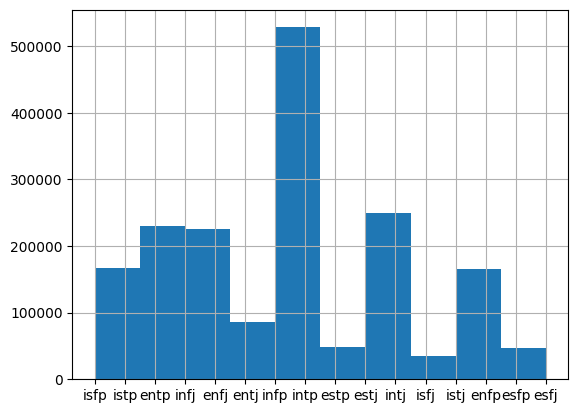

In [7]:
print(df['author_flair_css_class'].value_counts())
df['author_flair_css_class'].hist()

In [8]:
path = 'data/small_.csv'
df.to_csv(path, index=False)

In [9]:
new = pd.read_csv(path, index_col=False)
new

,author_flair_css_class,author_flair_text,id,author,body,parent_id,link_id,score
0,isfp,ISFP,d3r406m,madsweet,I'm an Fi user and I don't think I feel emotio...,t3_4lydf1,t3_4lydf1,5.0
1,istp,ISTP,d3r40sv,aNinjaWithAIDS,"I've always thought of Fi as ""*purity of one's...",t3_4lydf1,t3_4lydf1,4.0
2,entp,ENTP,d3r4lcr,Poropopper,"Hahaha, if I were ENTP we would clash, given t...",t1_d3qdjmg,t3_4lth6p,5.0
3,infj,INFJ,d3r4wt3,quiteafewfireflies,I don't really agree with this. An intuitive w...,t1_d3r41mk,t3_4lyfg3,5.0
4,enfj,ENFJ,d3r56tq,lawdudette,Yes! \n\nThis is my top answer anytime someone...,t1_d3r0byy,t3_4lwoo6,2.0
...,...,...,...,...,...,...,...,...
1919604,estj,ESTJ,j2fw424,diabolicalfrnchtoast,I don't get the impression that IxFPs get a ba...,t1_j2cfdcz,t3_zzlu5n,1.0
1919605,istp,ISTP,j2fwqqw,bob_prints_spaghetti,Congrats man. At least you're still spontaneou...,t3_1006762,t3_1006762,2.0
1919606,intp,INTP,j2fwv5e,Deep_Craft_3760,Don't tell me you made all the possible combin...,t3_1003lfy,t3_1003lfy,11.0
1919607,istp,ISTP,j2fwx7a,Zealousideal_Mix_629,"It's all about individual perspective, so it's...",t1_j2fsrf2,t3_zzu1je,1.0
